In [1]:
!gdown 1RJLpD5PVfLP5TBdFQ_yrp88hUkNkoM7o

Downloading...
From: https://drive.google.com/uc?id=1RJLpD5PVfLP5TBdFQ_yrp88hUkNkoM7o
To: /content/data.csv
100% 125k/125k [00:00<00:00, 6.13MB/s]


Total samples: 569, Total features: 30
------------------------------
Train Set: (341, 30) (Target ratio: 0.37)
Val Set:   (114, 30)   (Target ratio: 0.37)
Test Set:  (114, 30)  (Target ratio: 0.38)
------------------------------
PCA transformation done for visualization.


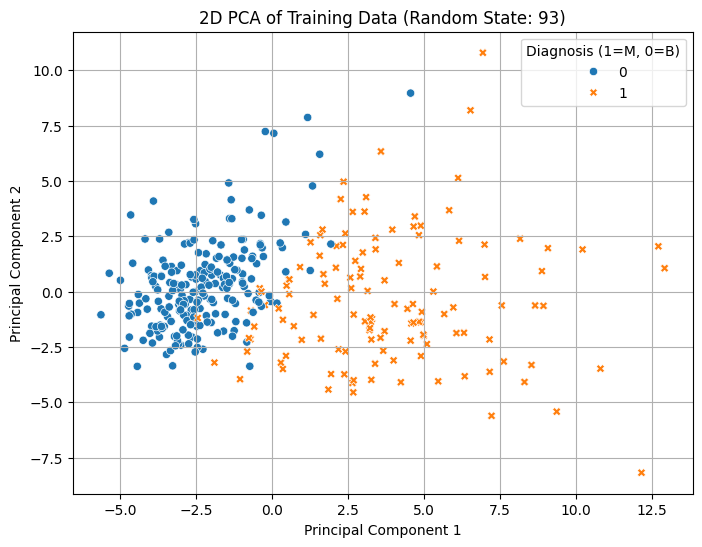

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 40122193 | 40120993
RANDOM_STATE = 93

df = pd.read_csv('data.csv')

if 'Unnamed: 32' in df.columns:
    df = df.drop(['Unnamed: 32'], axis=1)
if 'id' in df.columns:
    df = df.drop(['id'], axis=1)

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

y = y.map({'M': 1, 'B': 0})

print(f"Total samples: {X.shape[0]}, Total features: {X.shape[1]}")

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    stratify=y,
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print("-" * 30)
print(f"Train Set: {X_train.shape} (Target ratio: {y_train.mean():.2f})")
print(f"Val Set:   {X_val.shape}   (Target ratio: {y_val.mean():.2f})")
print(f"Test Set:  {X_test.shape}  (Target ratio: {y_test.mean():.2f})")
print("-" * 30)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2, random_state=RANDOM_STATE)

X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("PCA transformation done for visualization.")


plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, style=y_train)
plt.title(f'2D PCA of Training Data (Random State: {RANDOM_STATE})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Diagnosis (1=M, 0=B)')
plt.grid(True)
plt.show()

In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
import numpy as np


RANDOM_STATE = 93
FIXED_C = 1 # Selecting C=1 as the default value

final_svm_model = SVC(kernel='linear', C=FIXED_C, random_state=RANDOM_STATE)
final_svm_model.fit(X_train_scaled, y_train)

w = final_svm_model.coef_[0]
norm_w = np.linalg.norm(w)
geometric_margin = 1 / norm_w


print(f"Weight vector norm: {norm_w:.3f}")
print(f"Geometric Margin: {geometric_margin:.3f}")
print("-" * 70)

def get_model_metrics(X, y_true):
    """Calculate all metrics: Accuracy, Precision, Recall, F1, ROC-AUC."""
    y_pred = final_svm_model.predict(X)

    y_score = final_svm_model.decision_function(X)

    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_score)
    }

val_metrics = get_model_metrics(X_val_scaled, y_val)
test_metrics = get_model_metrics(X_test_scaled, y_test)

print("Model Performance Metrics Report")
print("-" * 70)
print(f"{'Metric':<12} | {'Validation Set':<20} | {'Test Set':<20}")
for metric_name in val_metrics:
    val_val = val_metrics[metric_name]
    test_val = test_metrics[metric_name]
    print(f"{metric_name:<12} | {val_val:.4f}{'':<16} | {test_val:.4f}{'':<16}")
print("-" * 70)

Weight vector norm: 2.764
Geometric Margin: 0.362
----------------------------------------------------------------------
Model Performance Metrics Report
----------------------------------------------------------------------
Metric       | Validation Set       | Test Set            
Accuracy     | 0.9737                 | 0.9825                
Precision    | 1.0000                 | 0.9767                
Recall       | 0.9286                 | 0.9767                
F1-Score     | 0.9630                 | 0.9767                
ROC-AUC      | 0.9927                 | 0.9990                
----------------------------------------------------------------------


In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd

C_values = [0.01, 0.1, 1, 10, 100]
results = []
for C in C_values:
    model = SVC(kernel='linear', C=C, random_state=RANDOM_STATE)
    model.fit(X_train_scaled, y_train)

    # weight vector
    w = model.coef_[0]
    w_norm = np.linalg.norm(w)
    margin = 1 / w_norm

    # evaluation on validation
    y_pred = model.predict(X_val_scaled)
    y_score = model.decision_function(X_val_scaled)

    acc  = accuracy_score(y_val, y_pred)
    pre  = precision_score(y_val, y_pred)
    rec  = recall_score(y_val, y_pred)
    f1   = f1_score(y_val, y_pred)
    auc  = roc_auc_score(y_val, y_score)

    # number of support vectors
    n_sv = sum(model.n_support_)

    results.append([C, acc, pre, rec, f1, auc, n_sv, margin])

# Create table
columns = ["C", "Accuracy", "Precision", "Recall", "F1", "ROC-AUC", "Num_SV", "Margin"]
df_results = pd.DataFrame(results, columns=columns)

print("\nSVM Linear Model Results for Various C\n")
print(df_results.to_string(index=False))



SVM Linear Model Results for Various C

      C  Accuracy  Precision  Recall    F1  ROC-AUC  Num_SV  Margin
  0.010     0.965      0.975   0.929 0.951    0.993      83   1.586
  0.100     0.982      0.976   0.976 0.976    0.995      45   0.769
  1.000     0.974      1.000   0.929 0.963    0.993      31   0.362
 10.000     0.947      0.929   0.929 0.929    0.987      24   0.132
100.000     0.886      0.809   0.905 0.854    0.967      23   0.042


Best C based on validation F1: 0.1
Best validation F1: 0.9762


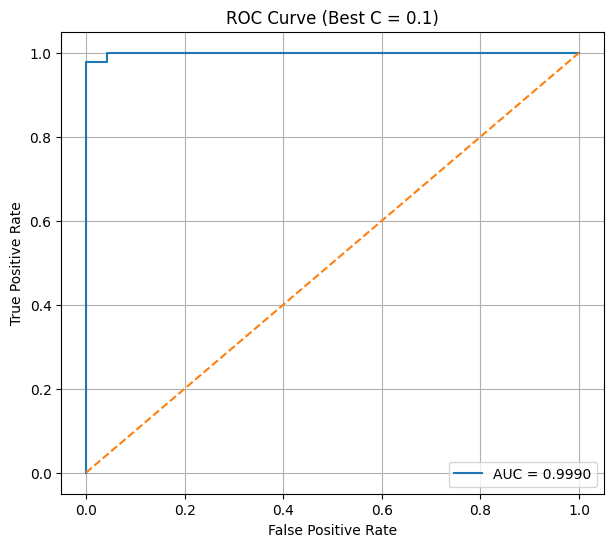

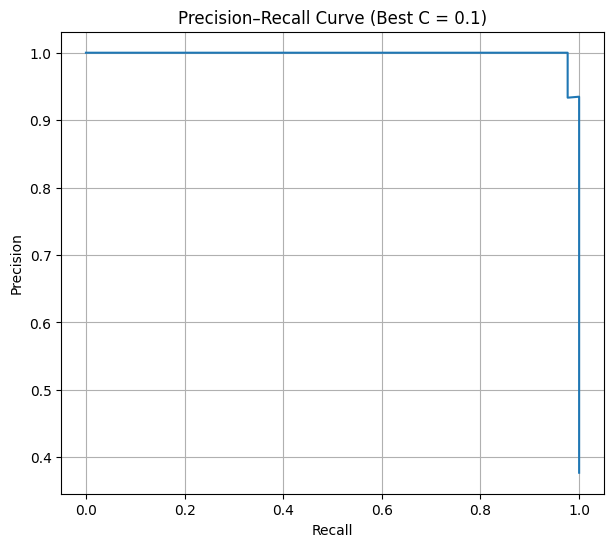

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve,
    f1_score
)
import matplotlib.pyplot as plt
import numpy as np

C_values = [0.01, 0.1, 1, 10, 100]

best_C = None
best_f1 = -1
best_model = None

# -------------------------------
# 1. انتخاب بهترین C با معیار F1 روی Validation
# -------------------------------
for C in C_values:
    model = SVC(kernel='linear', C=C, probability=True, random_state=93)
    model.fit(X_train_scaled, y_train)

    y_val_pred = model.predict(X_val_scaled)
    f1 = f1_score(y_val, y_val_pred)

    if f1 > best_f1:
        best_f1 = f1
        best_C = C
        best_model = model

print(f"Best C based on validation F1: {best_C}")
print(f"Best validation F1: {best_f1:.4f}")

# -------------------------------
# 2. محاسبه امتیازهای مدل روی Test برای نمودارها
# -------------------------------
y_test_score = best_model.decision_function(X_test_scaled)
y_test_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# ---- ROC Curve ----
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Best C = {best_C})")
plt.legend()
plt.grid(True)
plt.show()

# ---- Precision–Recall Curve ----
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)

plt.figure(figsize=(7, 6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (Best C = {best_C})")
plt.grid(True)
plt.show()


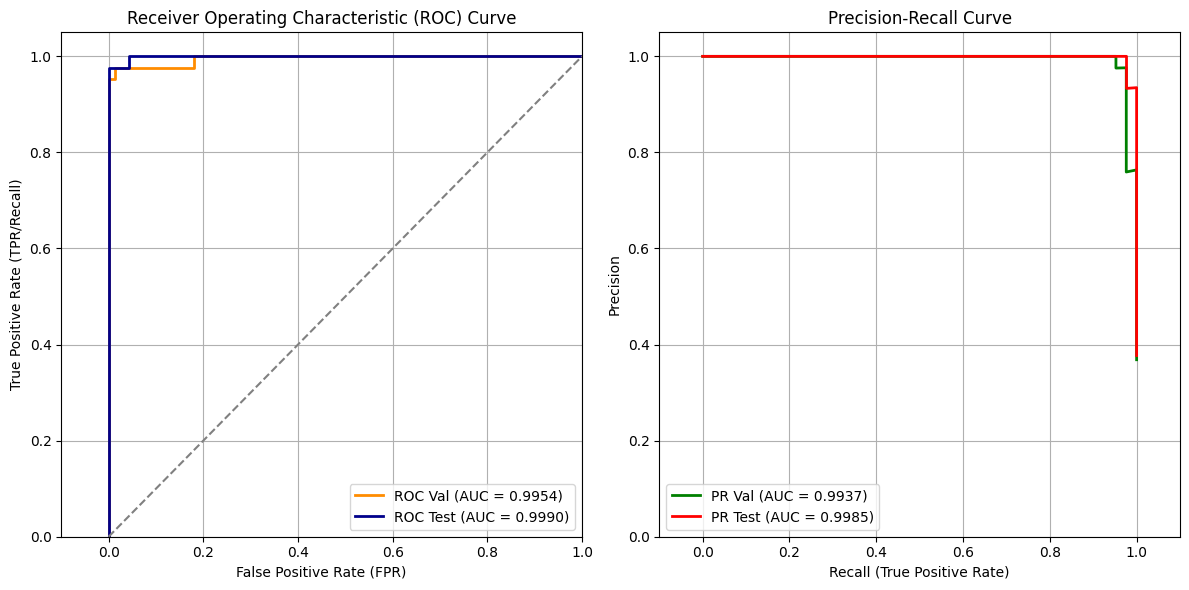

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.svm import SVC
import numpy as np

# --- فرض بر این است که متغیرهای داده استاندارد شده و برچسب‌ها در دسترس هستند ---
RANDOM_STATE = 93
BEST_C = 0.1 # بهترین C که از جدول تنظیمات انتخاب شد

# 1. آموزش مدل نهایی
final_model = SVC(kernel='linear', C=BEST_C, random_state=RANDOM_STATE)
final_model.fit(X_train_scaled, y_train)

# 2. محاسبه امتیازها (decision scores) برای هر دو مجموعه
# امتیازها برای رسم ROC/PR نیاز هستند (فاصله تا ابرصفحه)
val_scores = final_model.decision_function(X_val_scaled)
test_scores = final_model.decision_function(X_test_scaled)

# =========================================================
# بخش ۱: رسم منحنی ROC و محاسبه AUC
# =========================================================

# محاسبه FPR, TPR و آستانه‌ها برای Validation
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_scores)
roc_auc_val = auc(fpr_val, tpr_val)

# محاسبه FPR, TPR و آستانه‌ها برای Test
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_scores)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(12, 6))

# منحنی ROC
plt.subplot(1, 2, 1)
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'ROC Val (AUC = {roc_auc_val:.4f})')
plt.plot(fpr_test, tpr_test, color='darkblue', lw=2, label=f'ROC Test (AUC = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR/Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)


# =========================================================
# بخش ۲: رسم منحنی Precision-Recall و محاسبه AUC
# =========================================================

# محاسبه Precision, Recall و آستانه‌ها برای Validation
precision_val, recall_val, thresholds_pr_val = precision_recall_curve(y_val, val_scores)
# AUC زیر منحنی Precision-Recall (PR-AUC)
pr_auc_val = auc(recall_val, precision_val)

# محاسبه Precision, Recall و آستانه‌ها برای Test
precision_test, recall_test, thresholds_pr_test = precision_recall_curve(y_test, test_scores)
pr_auc_test = auc(recall_test, precision_test)

# منحنی Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(recall_val, precision_val, color='green', lw=2, label=f'PR Val (AUC = {pr_auc_val:.4f})')
plt.plot(recall_test, precision_test, color='red', lw=2, label=f'PR Test (AUC = {pr_auc_test:.4f})')
plt.xlim([-0.1, 1.1])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.show()